In [1]:
from io import open
import glob
import os
import unicodedata
import string
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import time
import math
%matplotlib inline

In [2]:
!pip install torch-summary

In [3]:
image=np.array(Image.open("/kaggle/input/wordcloud-mask-collection/stormtrooper_mask.png"))

In [4]:
data="/kaggle/input/arabic-surnames-datase/data/names/"
names_files=os.listdir(data)
print(names_files)

['Vietnamese.txt', 'Greek.txt', 'Japanese.txt', 'Dutch.txt', 'Irish.txt', 'Russian.txt', 'Korean.txt', 'Scottish.txt', 'Czech.txt', 'Italian.txt', 'Arabic.txt', 'Portuguese.txt', 'Spanish.txt', 'Chinese.txt', 'French.txt', 'English.txt', 'German.txt', 'Polish.txt']


In [5]:
def findFiles(path):
    return glob.glob(path)

In [6]:
findFiles("/kaggle/input/arabic-surnames-datase/data/names/*.txt")

['/kaggle/input/arabic-surnames-datase/data/names/Vietnamese.txt',
 '/kaggle/input/arabic-surnames-datase/data/names/Greek.txt',
 '/kaggle/input/arabic-surnames-datase/data/names/Japanese.txt',
 '/kaggle/input/arabic-surnames-datase/data/names/Dutch.txt',
 '/kaggle/input/arabic-surnames-datase/data/names/Irish.txt',
 '/kaggle/input/arabic-surnames-datase/data/names/Russian.txt',
 '/kaggle/input/arabic-surnames-datase/data/names/Korean.txt',
 '/kaggle/input/arabic-surnames-datase/data/names/Scottish.txt',
 '/kaggle/input/arabic-surnames-datase/data/names/Czech.txt',
 '/kaggle/input/arabic-surnames-datase/data/names/Italian.txt',
 '/kaggle/input/arabic-surnames-datase/data/names/Arabic.txt',
 '/kaggle/input/arabic-surnames-datase/data/names/Portuguese.txt',
 '/kaggle/input/arabic-surnames-datase/data/names/Spanish.txt',
 '/kaggle/input/arabic-surnames-datase/data/names/Chinese.txt',
 '/kaggle/input/arabic-surnames-datase/data/names/French.txt',
 '/kaggle/input/arabic-surnames-datase/data

In [7]:
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)
print(all_letters)
print("================================================")
print(n_letters)

abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'
57


In [8]:
def unicodeToAscii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'and c in all_letters)

print(unicodeToAscii('Ślusàrski'))

Slusarski


# Build the category_lines dictionary, a list of names per language

In [9]:
category_lines = {}
all_categories = []

def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('/kaggle/input/arabic-surnames-datase/data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

In [10]:
n_categories = len(all_categories)
n_categories

18

```
Now we have category_lines, a dictionary mapping each category (language) to a list of lines (names). We also kept track of all_categories (just a list of languages) and n_categories for later reference.

```

In [11]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


# Read the names from each file and store in a dictionary

In [12]:
names_data = {}
for file in names_files:
    language = file.replace('.txt', '')  # Extract language from file name
    file_path = os.path.join(data, file)  # Correct path to the file
    with open(file_path, 'r', encoding='utf-8') as f:
        names_data[language] = f.read().splitlines()


# Create a DataFrame to hold the counts of names per language

In [13]:
names_count = {language: len(names) for language, names in names_data.items()}
df_names_count = pd.DataFrame(list(names_count.items()), columns=['Language', 'Name Count'])
df_names_count.head()

,Language,Name Count
0,Vietnamese,73
1,Greek,203
2,Japanese,991
3,Dutch,297
4,Irish,232


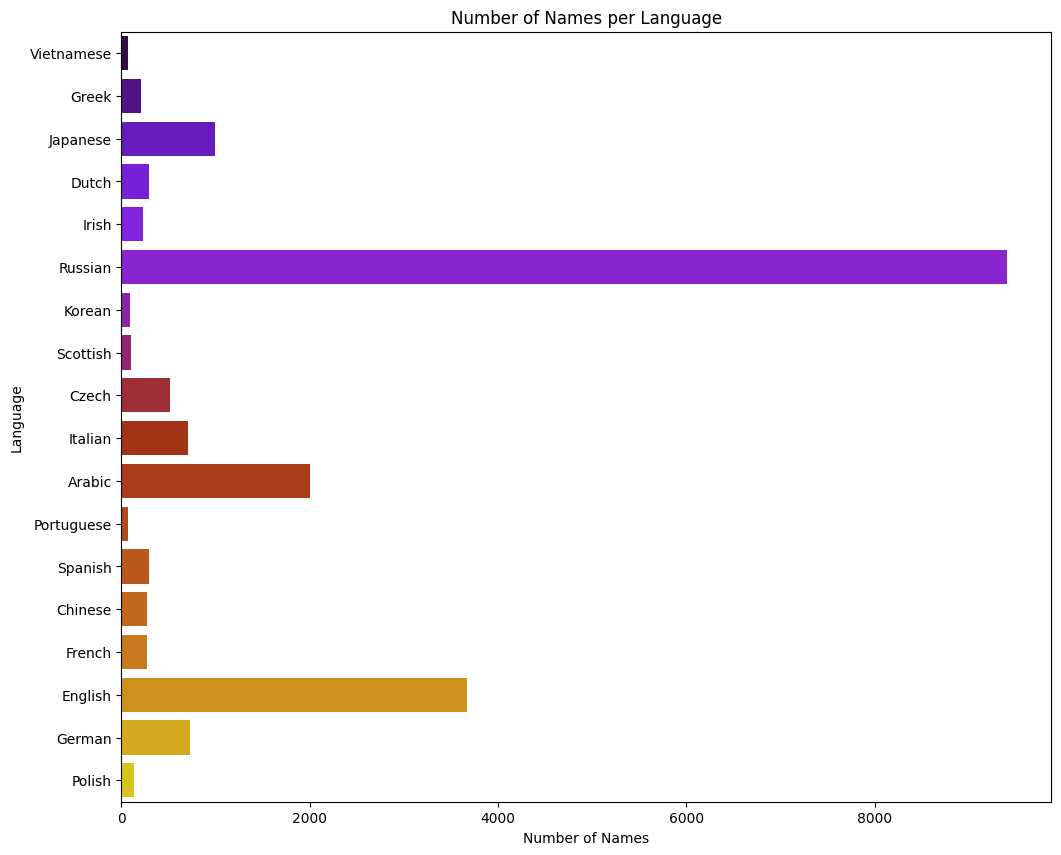

In [14]:
plt.figure(figsize=(12, 10))
sns.barplot(x='Name Count', y='Language', data=df_names_count, palette='gnuplot')
plt.title('Number of Names per Language')
plt.xlabel('Number of Names')
plt.ylabel('Language')
plt.show()

# Visualization 2: Word Cloud (For all names combined)

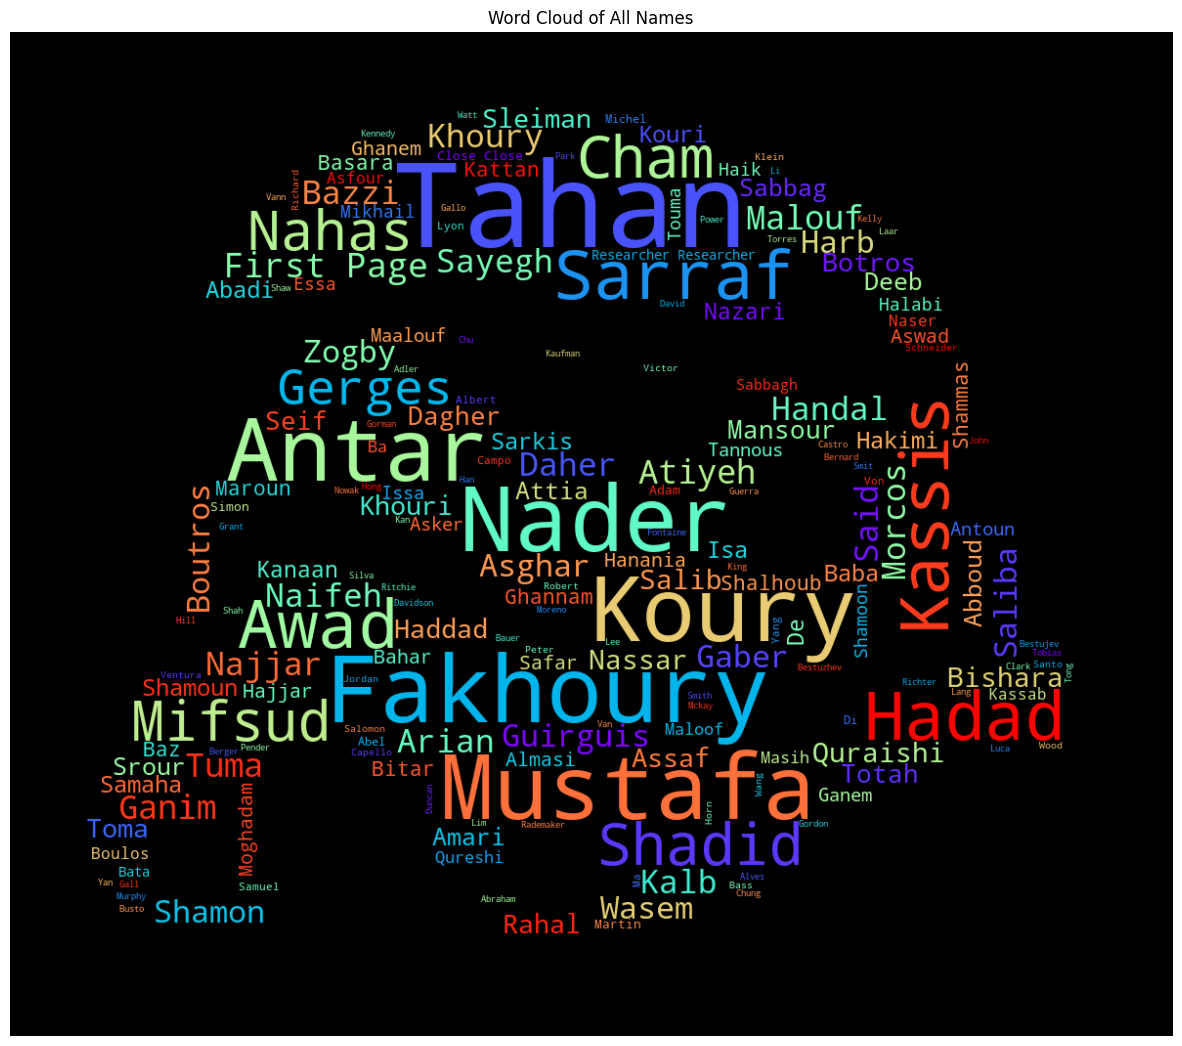

In [15]:
all_names = ' '.join([name for names in names_data.values() for name in names])
wordcloud = WordCloud(width=800, height=600, background_color='black',colormap="rainbow",mask=image).generate(all_names)

plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of All Names')
plt.show()


# Visualization 2: Word Cloud (For all names combined)

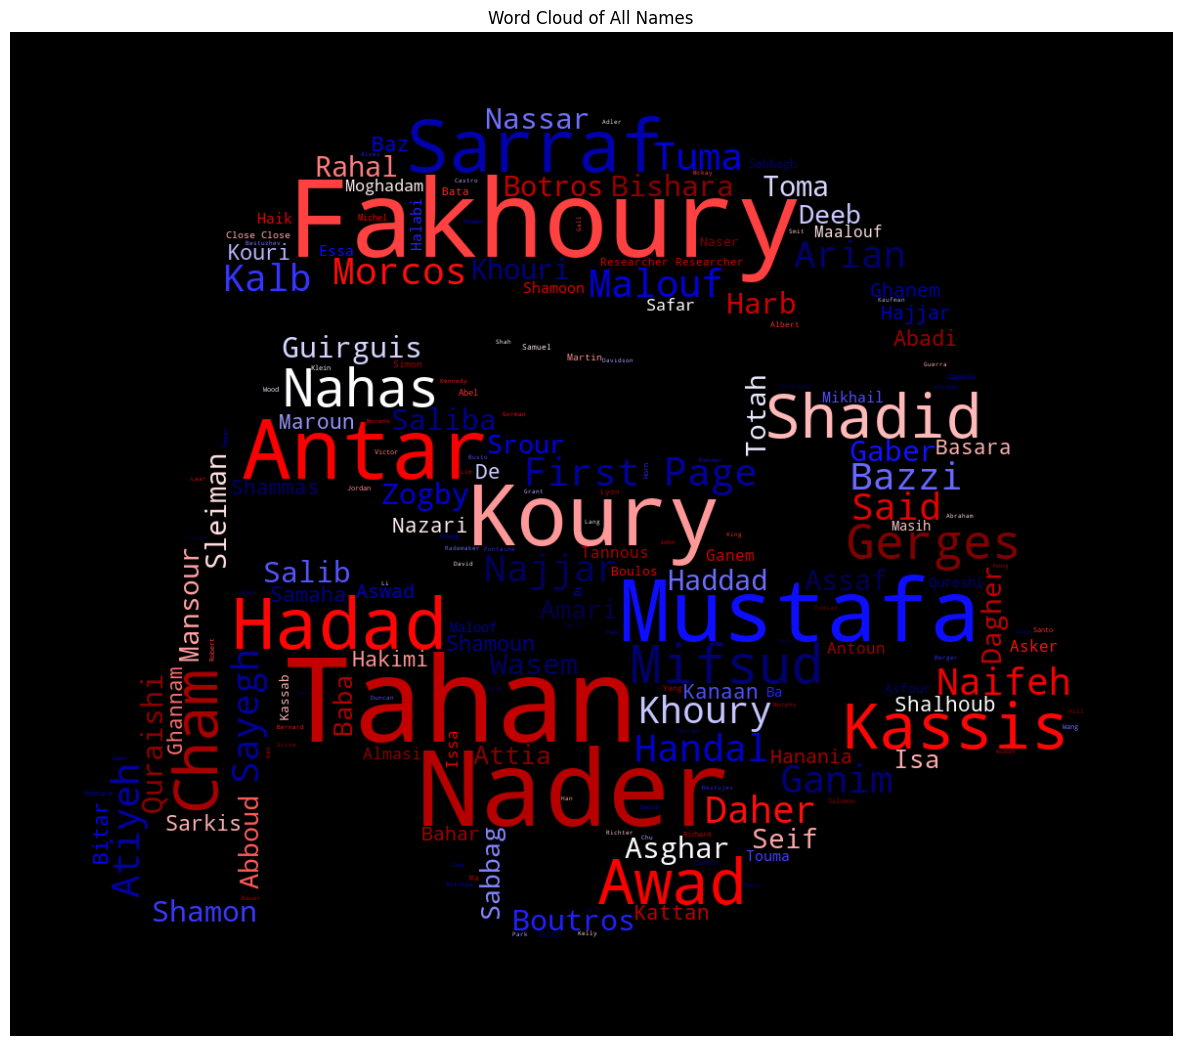

In [16]:
all_names = ' '.join([name for names in names_data.values() for name in names])
wordcloud = WordCloud(width=800, height=600, background_color='black',colormap="seismic",mask=image).generate(all_names)

plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of All Names')
plt.show()

# Visualization 3: Pie Chart of Language Distribution

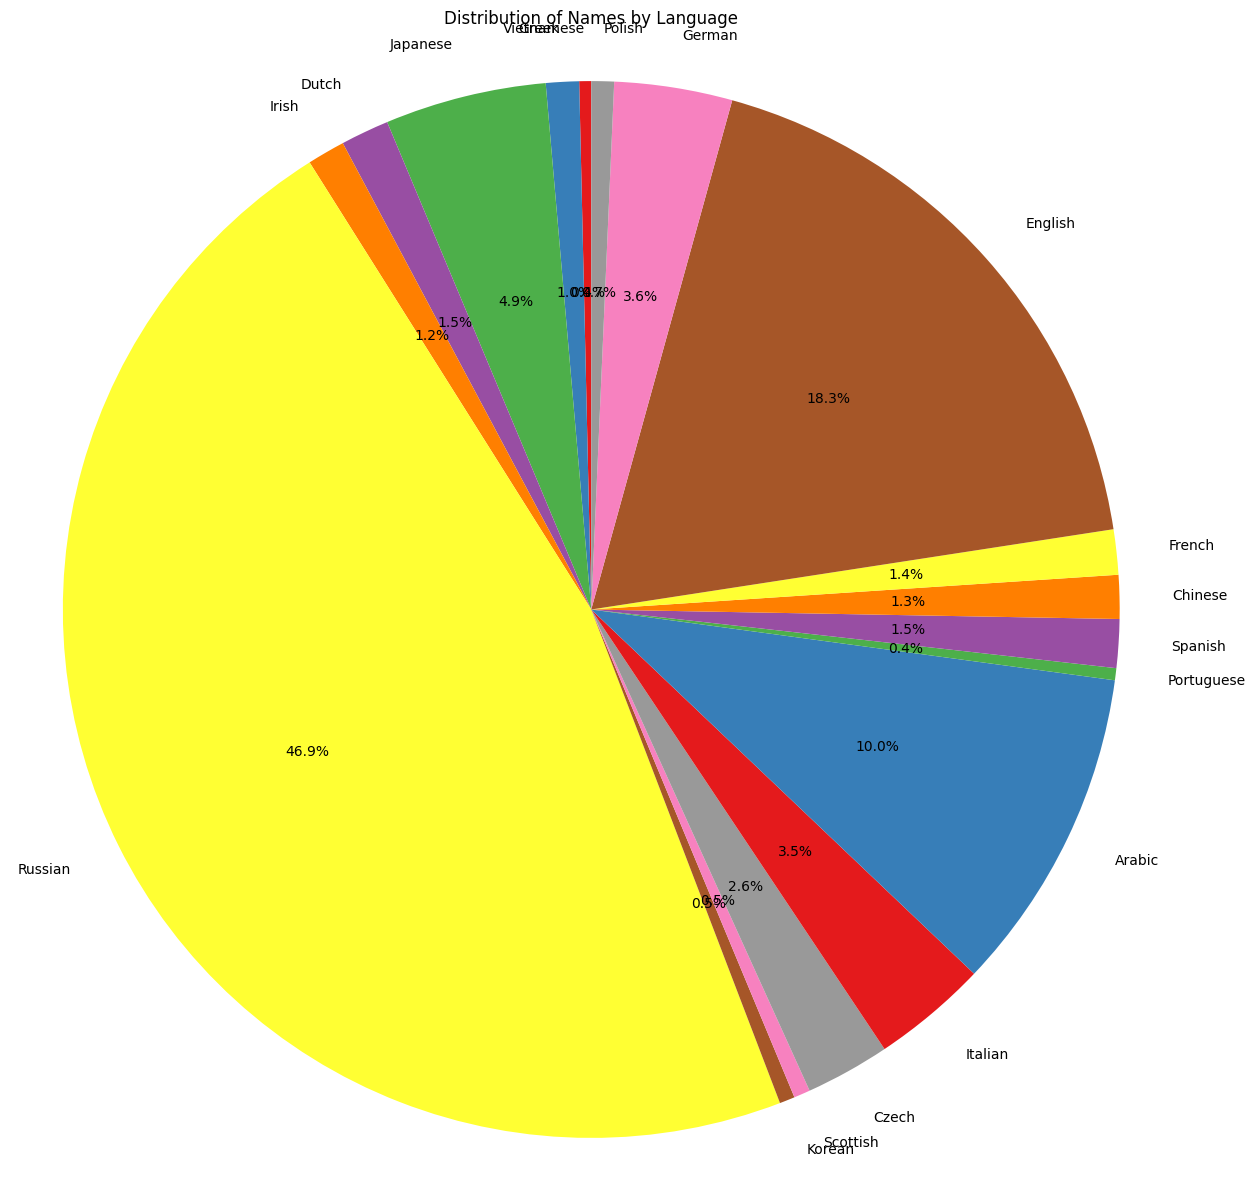

In [17]:
plt.figure(figsize=(15,15))
plt.pie(df_names_count['Name Count'], labels=df_names_count['Language'], autopct='%1.1f%%', startangle=90, colors=sns.color_palette('Set1', len(df_names_count)))
plt.title('Distribution of Names by Language')
plt.axis('equal')
plt.show()

# Visualization 4: Box Plot (Name Length Distribution)

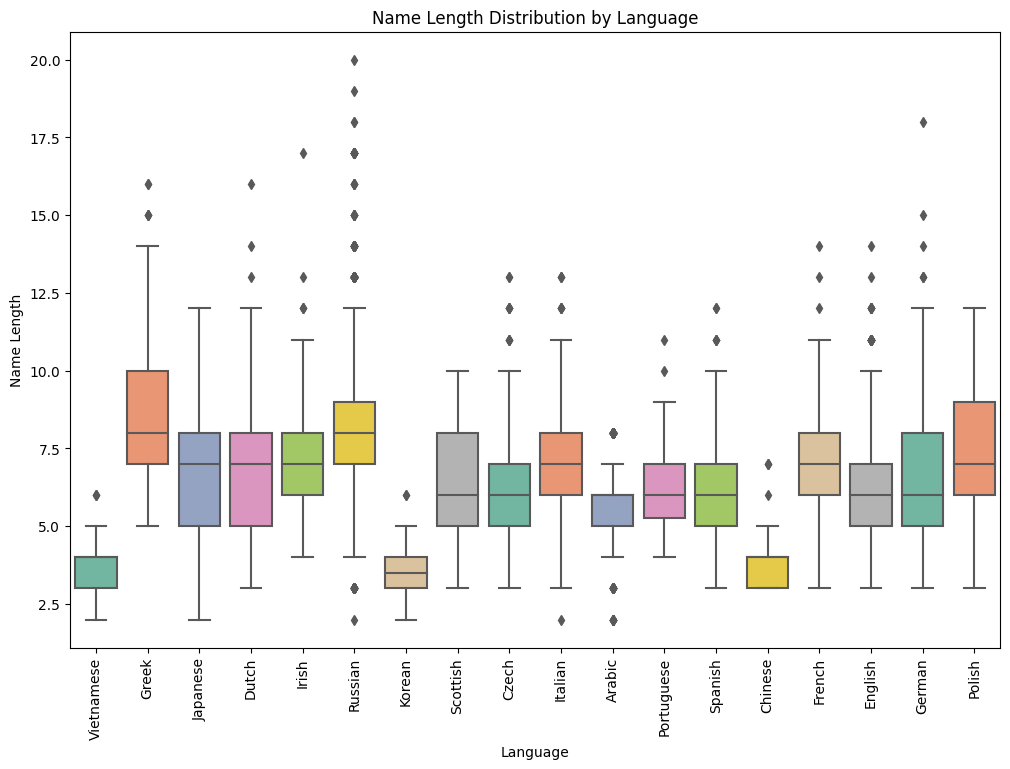

In [18]:
name_lengths = {language: [len(name) for name in names] for language, names in names_data.items()}
df_name_lengths = pd.DataFrame.from_dict(name_lengths, orient='index').transpose()

plt.figure(figsize=(12, 8))
sns.boxplot(data=df_name_lengths, palette='Set2')
plt.title('Name Length Distribution by Language')
plt.xlabel('Language')
plt.ylabel('Name Length')
plt.xticks(rotation=90)
plt.show()

In [19]:
from collections import Counter
names_data = {}
for file in names_files:
    language = file.replace('.txt', '')
    file_path = os.path.join(data, file)
    with open(file_path, 'r', encoding='utf-8') as f:
        names_data[language] = f.read().splitlines()

all_names = [name for names in names_data.values() for name in names]
all_words = [word.lower() for name in all_names for word in name.split()]
word_counts = Counter(all_words)
most_common_words = word_counts.most_common(20)

In [20]:
print("Most Common Words:")
for word, count in most_common_words:
    print(f"{word}: {count}")

Most Common Words:
tahan: 28
fakhoury: 28
nader: 27
mustafa: 27
koury: 27
page: 26
antar: 26
sarraf: 26
hadad: 26
kassis: 26
to: 25
first: 25
awad: 25
shadid: 25
cham: 25
mifsud: 25
the: 24
nahas: 24
gerges: 24
tuma: 23


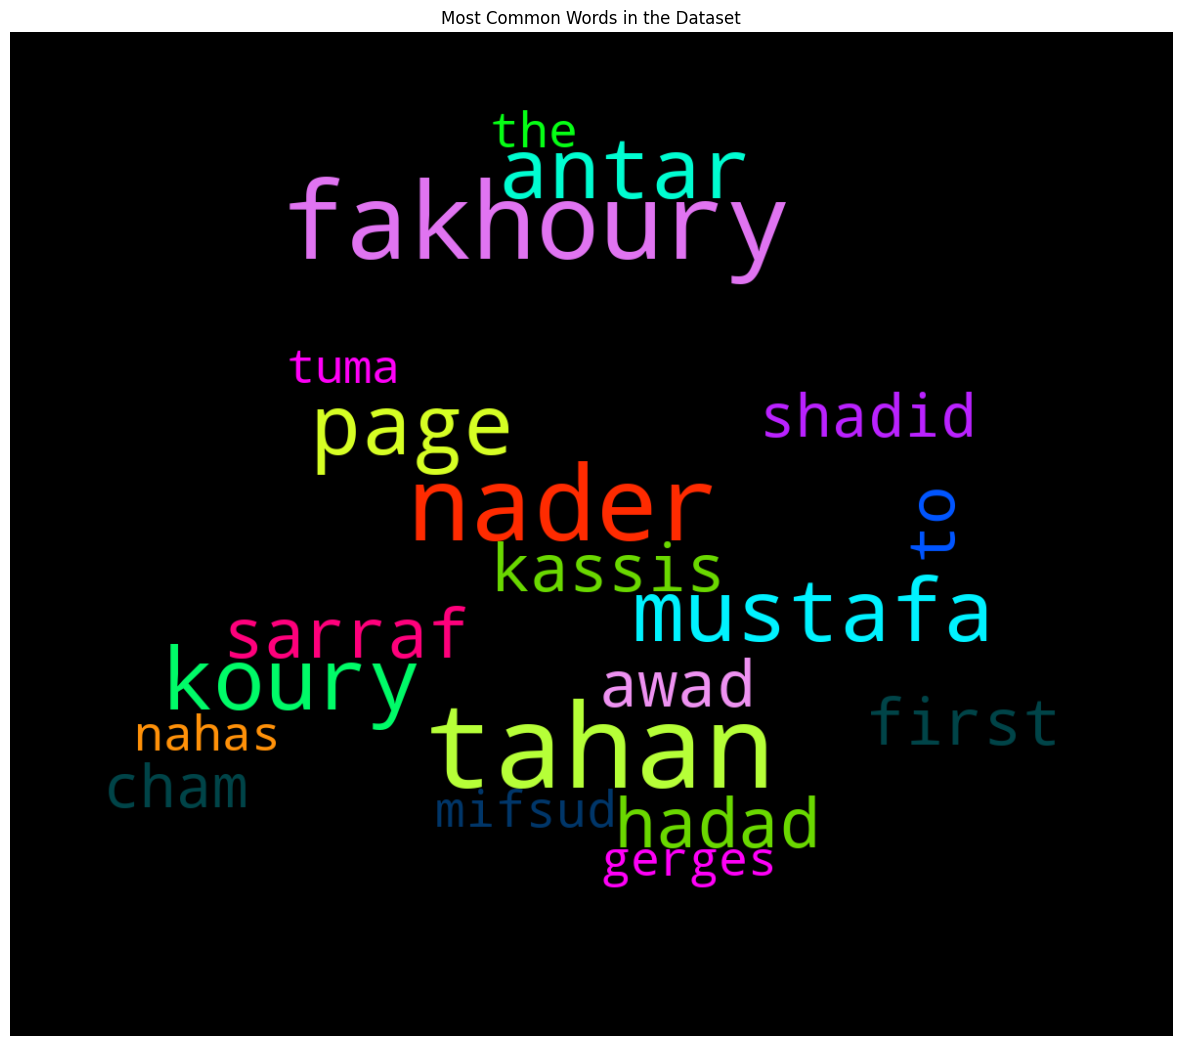

In [21]:
wordcloud = WordCloud(width=800, height=600, background_color='black',colormap='gist_ncar',mask=image).generate_from_frequencies(dict(most_common_words))

plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in the Dataset')
plt.show()

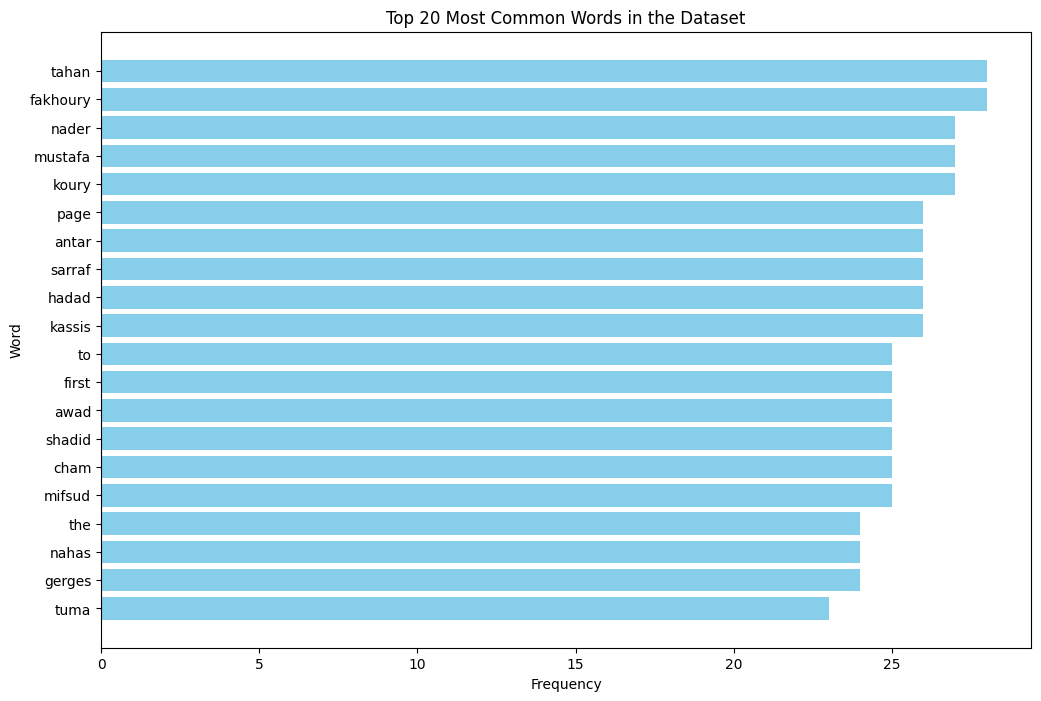

In [22]:
most_common_df = pd.DataFrame(most_common_words, columns=['Word', 'Frequency'])

plt.figure(figsize=(12, 8))
plt.barh(most_common_df['Word'], most_common_df['Frequency'], color='skyblue')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.title('Top 20 Most Common Words in the Dataset')
plt.gca().invert_yaxis()
plt.show()


# Find letter index from all_letters, e.g. "a" = 0

In [23]:
def letterToIndex(letter):
    return all_letters.find(letter)



# Just for demonstration, turn a letter into a <1 x n_letters> Tensor

In [24]:
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

In [25]:
# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])


In [26]:
print(lineToTensor('Jones').size())

torch.Size([5, 1, 57])


# Creating the Network

In [27]:
from torchsummary import summary

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        hidden = F.tanh(self.i2h(input) + self.h2h(hidden))
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)
summary(rnn, input_size=(1, n_letters))

Layer (type:depth-idx)                   Param #
├─Linear: 1-1                            7,424
├─Linear: 1-2                            16,512
├─Linear: 1-3                            2,322
├─LogSoftmax: 1-4                        --
Total params: 26,258
Trainable params: 26,258
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Linear: 1-1                            7,424
├─Linear: 1-2                            16,512
├─Linear: 1-3                            2,322
├─LogSoftmax: 1-4                        --
Total params: 26,258
Trainable params: 26,258
Non-trainable params: 0

In [28]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

In [29]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.8553, -2.8977, -2.8528, -2.8858, -2.8129, -2.9339, -2.8887, -2.8485,
         -3.0600, -2.8784, -2.8778, -2.8252, -2.8035, -2.9501, -3.0398, -2.8483,
         -3.0037, -2.8130]], grad_fn=<LogSoftmaxBackward0>)


# Preparing for Training

```
Before going into training we should make a few helper functions. The first is to interpret the output of the network, which we know to be a likelihood of each category. We can use Tensor.topk to get the index of the greatest value:
```

In [30]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Spanish', 12)


# We will also want a quick way to get a training example (a name and its language):



In [31]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

In [32]:
for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Portuguese / line = Souza
category = German / line = Von wegberg
category = Spanish / line = Benitez
category = English / line = Pitchford
category = Czech / line = Kratschmar
category = Czech / line = Hawlata
category = Italian / line = Abatangelo
category = Dutch / line = Mulder
category = French / line = Archambault
category = English / line = Coburn


In [33]:
criterion = nn.NLLLoss()

In [34]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [35]:
n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print ``iter`` number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 8s) 3.0608 Dalach / Czech ✗ (Irish)
10000 10% (0m 16s) 2.6379 Spijker / German ✗ (Dutch)
15000 15% (0m 25s) 0.5767 Polymenakou / Greek ✓
20000 20% (0m 33s) 0.7642 Matsukata / Japanese ✓
25000 25% (0m 41s) 2.6282 Meier / German ✗ (Czech)
30000 30% (0m 49s) 0.9699 Otsu / Japanese ✓
35000 35% (0m 58s) 2.0800 Duguay / Scottish ✗ (French)
40000 40% (1m 6s) 2.9743 Dirchs / English ✗ (German)
45000 45% (1m 15s) 0.2129 Seok / Korean ✓
50000 50% (1m 23s) 0.3881 Murray / Scottish ✓
55000 55% (1m 31s) 0.0751 Luong / Vietnamese ✓
60000 60% (1m 39s) 0.5284 Dresdner / German ✓
65000 65% (1m 47s) 0.1137 Hagiwara / Japanese ✓
70000 70% (1m 55s) 0.2220 Luc / Vietnamese ✓
75000 75% (2m 3s) 0.1159 Jakimchuk / Russian ✓
80000 80% (2m 11s) 0.9557 Lippi / Italian ✓
85000 85% (2m 19s) 0.3723 Hatakeda / Japanese ✓
90000 90% (2m 27s) 0.9225 Mo / Vietnamese ✗ (Korean)
95000 95% (2m 36s) 0.0094 Kikutake / Japanese ✓
100000 100% (2m 44s) 2.6885 Arthur / German ✗ (French)


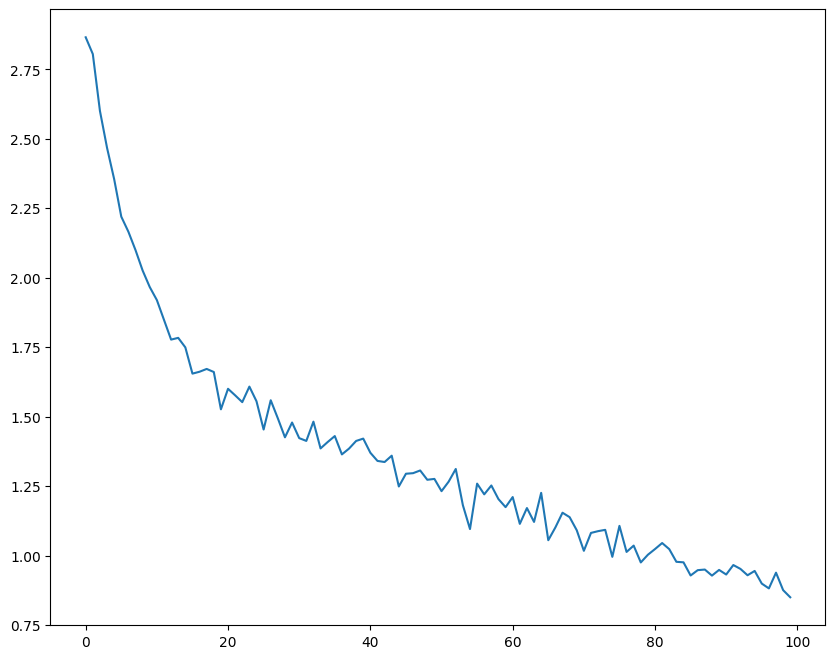

In [36]:

plt.figure(figsize=(10,8))
plt.plot(all_losses)
plt.show()


# Evaluating the Results

/tmp/ipykernel_183/3570256630.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
/tmp/ipykernel_183/3570256630.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


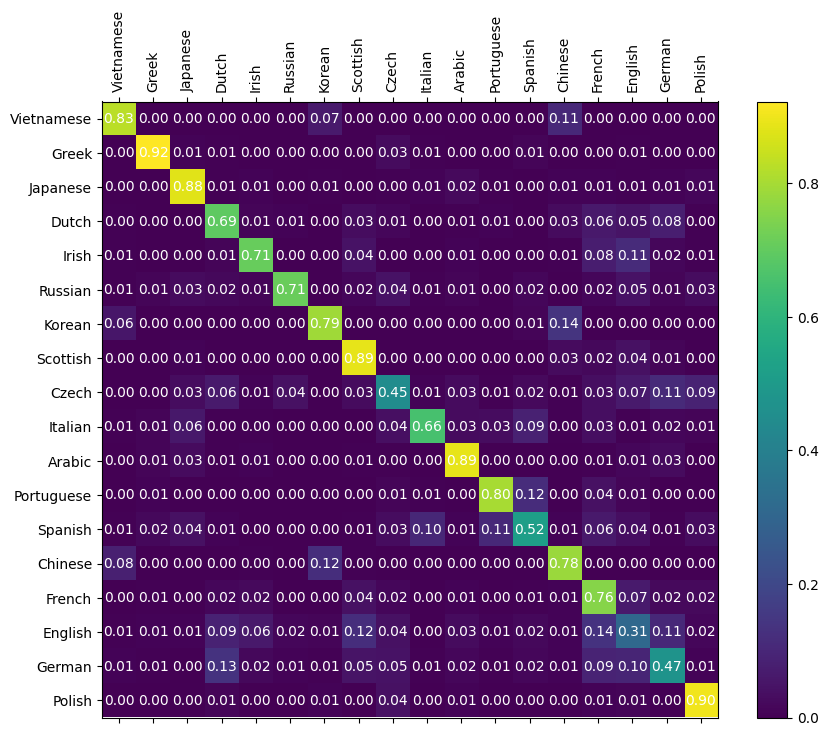

In [37]:
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

def evaluate(line_tensor):
    hidden = rnn.initHidden()
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    return output

for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

for (i, j), val in np.ndenumerate(confusion.numpy()):
    ax.text(j, i, f'{val:.2f}', ha='center', va='center', color='white')

plt.show()


# Running on User Input

In [38]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.87) Russian
(-1.31) English
(-1.72) Czech

> Jackson
(-0.03) Scottish
(-3.60) English
(-5.36) German

> Satoshi
(-0.12) Japanese
(-2.92) Polish
(-3.51) Italian
